In [27]:
"""You have to run flowers_init once before this code can be executed"""

'You have to run flowers_init once before this code can be executed'

In [1]:
import time
import numpy as np
import pandas as pd
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
#import matplotlib
import matplotlib.pyplot as plt
import pickle
#from sklearn.metrics import confusion_matrix
from keras.applications import InceptionV3
import os
from keras import optimizers
#import itertools
#from keras.optimizers import SGD, Adam, RMSprop, Nadam

import tensorflow as tf
import keras
from keras.callbacks import Callback
startTime = time.time()
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12}) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.00
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("---------------------------------------------------------------")
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
np.random.seed(1)

Using TensorFlow backend.


---------------------------------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5740349354189184332
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11811160064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18224527666489958673
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


In [2]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
train_images = pickle.load(open("train_images.pkl", "rb"))
val_images = pickle.load(open("val_images.pkl", "rb"))
test_images = pickle.load(open("test_images.pkl", "rb"))

In [4]:
base_dir = 'flowers_split'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [6]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048)) #features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if (i + 1) * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, len(train_images))#2000)
validation_features, validation_labels = extract_features(validation_dir, len(val_images))#1000)
test_features, test_labels = extract_features(test_dir, len(test_images))#1000)

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [8]:
train_features = np.reshape(train_features, (len(train_images), 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (len(val_images), 3 * 3 * 2048))
test_features = np.reshape(test_features, (len(test_images), 3 * 3 * 2048))

In [9]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [10]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2595 samples, validate on 865 samples
Epoch 1/30
2595/2595 [==============================] - 3s 1ms/step - loss: 1.2410 - acc: 0.5572 - val_loss: 0.7014 - val_acc: 0.7434
Epoch 2/30
2595/2595 [==============================] - 1s 532us/step - loss: 0.7168 - acc: 0.7287 - val_loss: 0.6244 - val_acc: 0.7699
Epoch 3/30
2595/2595 [==============================] - 1s 528us/step - loss: 0.5681 - acc: 0.7908 - val_loss: 0.5895 - val_acc: 0.8000
Epoch 4/30
2595/2595 [==============================] - 1s 519us/step - loss: 0.4577 - acc: 0.8301 - val_loss: 0.5998 - val_acc: 0.7942
Epoch 5/30
2595/2595 [==============================] - 1s 528us/step - loss: 0.3810 - acc: 0.8640 - val_loss: 0.5833 - val_acc: 0.7965
Epoch 6/30
2595/2595 [==============================] - 1s 499us/step - loss: 0.3340 - acc: 0.8778 - val_loss: 0.5848 - val_acc: 0.8035
Epoch 7/30
2595/2595 [==============================] - 1s 523us/step - loss: 0.2708 - acc: 0.9002 - val_loss: 0.5639 - val_acc: 0.8150
Epo

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [40]:
epochs = range(len(acc))

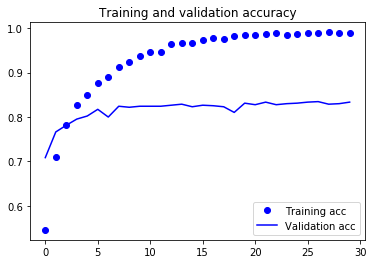

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
#plt.savefig('pre_train_acc.png', bbox_inches='tight')

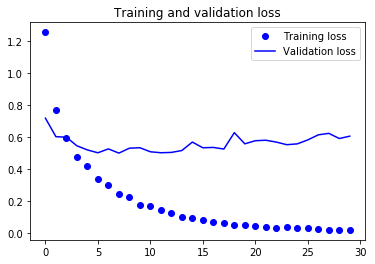

In [42]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('pre_train_val.png', bbox_inches='tight')
plt.show()
#plt.savefig('pre_train_loss.png', bbox_inches='tight')

In [43]:
pred_result = model.predict(test_features,
                            batch_size=(batch_size+1),
                            verbose=0)

In [47]:
"""This part needs fixing"""
labels=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
labels_d={'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

df = pd.DataFrame(np.zeros((5, 5)),index=labels , columns=labels)

for i in range(0, len(pred_result[:,0])): 
    maxV = 0
    j = 0
    correct_index = -1
    for j in range(0, len(pred_result[0,:])):
        if test_labels[i][j] == 1:
            correct_index = j
        if pred_result[i,j] > maxV:
            maxV = pred_result[i,j]
            maxIndex = j
    df.iloc[maxIndex, correct_index] += 1
print("confusion matrix: rows are predictions, columns are the correct answers")
print(df)

           daisy  dandelion   rose  sunflower  tulip
daisy      112.0       11.0    3.0        4.0    2.0
dandelion    8.0      205.0    2.0        4.0   12.0
rose         4.0        3.0  123.0        6.0   11.0
sunflower    5.0        7.0    8.0      132.0    7.0
tulip        7.0        7.0   17.0        4.0  162.0


In [45]:
endTime = time.time()
print(endTime - startTime)

74.20707845687866
